### Импорт используемых библиотек

In [172]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

### Чтение данных

In [261]:
true_test_data = np.array(pd.read_csv('test.csv').drop(['Id','physics', 'history', 'geography','english','biology', 'chemistry'], 1))
true_train_data = np.array(pd.read_csv('train.csv').drop(['Id','choose','physics', 'history', 'geography','english','biology', 'chemistry'], 1))
true_train_labels = np.array(pd.read_csv('train.csv')['choose'])

### Обработка данных

1. Отмасштабируем получившиеся признаки методом стандартизации.

In [262]:
# Получим средние значения и стандартное отклонение по столбцам

means = np.mean(true_train_data, axis=0)
stds = np.std(true_train_data, axis=0)
# параметр axis указывается для вычисления значений по столбцам, а не по всему массиву
#(см. документацию в разделе источников)

# вычтем каждое значение признака из среднего и поделим на стандартное отклонение
for i in range(true_train_data.shape[0]):
    for j in range(true_train_data.shape[1]):
        true_train_data[i][j] = (true_train_data[i][j] - means[j])/stds[j]

In [263]:
# Получим средние значения и стандартное отклонение по столбцам

means = np.mean(true_test_data, axis=0)
stds = np.std(true_test_data, axis=0)
# параметр axis указывается для вычисления значений по столбцам, а не по всему массиву
#(см. документацию в разделе источников)

# вычтем каждое значение признака из среднего и поделим на стандартное отклонение
for i in range(true_test_data.shape[0]):
    for j in range(true_test_data.shape[1]):
        true_test_data[i][j] = (true_test_data[i][j] - means[j])/stds[j]

In [264]:
pd.DataFrame(true_test_data)

,0,1,2,3,4
0,-1.733720,0.008074,1.900467,1.643482,1.905063
1,-1.360194,2.266521,0.190201,0.377024,0.504856
2,-0.239617,0.008074,-0.949977,-0.889433,-1.411218
3,-0.239617,1.137298,2.375541,1.643482,2.052454
4,-0.986668,0.572686,-0.569918,0.377024,-0.453181
...,...,...,...,...,...
9995,-0.239617,0.572686,0.285215,0.377024,0.283770
9996,-0.115108,0.572686,1.425393,0.377024,0.578551
9997,-0.239617,0.008074,-0.854962,-0.889433,-0.084705
9998,0.631943,1.701909,-1.330036,0.377024,-0.011010


Отбалансируем данные

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x27A45D10>]],
      dtype=object)

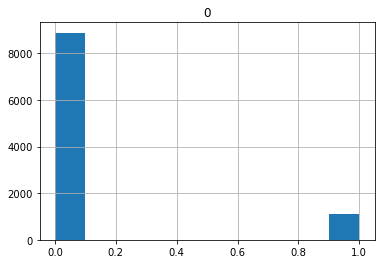

In [224]:
pd.DataFrame(true_train_labels).hist()

Как видно из тренировочной выборки, целевая переменная неотбалансированна. Сгенерируем новые данные,чтобы избежать этого:

In [225]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2)

X_train_res, y_train_res = sm.fit_sample(true_train_data, true_train_labels.ravel())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15E3AE70>]],
      dtype=object)

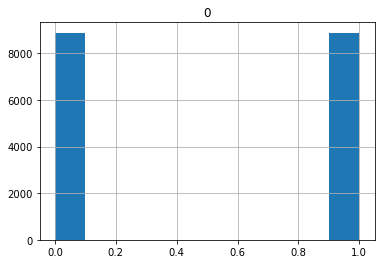

In [226]:
pd.DataFrame(y_train_res).hist()

In [227]:
print("Before OverSampling, counts of label '1': {}".format(sum(true_train_labels == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(true_train_labels == 0)))


print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 1109
Before OverSampling, counts of label '0': 8891 

After OverSampling, the shape of train_X: (17782, 5)
After OverSampling, the shape of train_y: (17782,) 

After OverSampling, counts of label '1': 8891
After OverSampling, counts of label '0': 8891


2. Вторым шагом в обработке эмпирическим путем были удалены признаки, не влияющие на предсказания модели. Ими оказались все признаки, относящиеся к предметам ('physics', 'history', 'geography','english','biology', 'chemistry'). Они были удалены из данных уже на этапе чтения

## Реализация случайного леса

Для лучшего понимания алгоритма построения случайного леса реализуем его на Python.

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [182]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [183]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Далее построим реализацию построения дерева решений

In [184]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [185]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [186]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [187]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [188]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [189]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [190]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [191]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [192]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [193]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [194]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее.

In [228]:
# Разобьем выборку на обучающую и тестовую

train_data, test_data, train_labels, test_labels = train_test_split(X_train_res, 
                                                                    y_train_res, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [229]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Построим случайный лес на валидационных данных и проверим точность модели

Построим лес из 10 деревьев

In [230]:
n_trees = 10
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [231]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [232]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [233]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 97.630


In [234]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 89.653


Точность нас устраивает, можно строить модель на всех данных 

### Построение модель на всех данных

In [242]:
n_trees = 30
my_forest_3 = random_forest(X_train_res, y_train_res, n_trees)

In [243]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, X_train_res)

In [253]:
true_test_data

array([[3.20e+01, 2.00e+00, 2.70e+03, 3.00e+00, 9.00e+01],
       [3.50e+01, 6.00e+00, 1.80e+03, 2.00e+00, 7.10e+01],
       [4.40e+01, 2.00e+00, 1.20e+03, 1.00e+00, 4.50e+01],
       ...,
       [4.40e+01, 2.00e+00, 1.25e+03, 1.00e+00, 6.30e+01],
       [5.10e+01, 5.00e+00, 1.00e+03, 2.00e+00, 6.40e+01],
       [4.30e+01, 0.00e+00, 1.50e+03, 1.00e+00, 4.10e+01]])

In [265]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, true_test_data)

In [266]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train_res, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 30 деревьев на обучающей выборке: 98.285


### Формируем файл для загрузки

In [267]:
submission_example = pd.read_csv('submission_example.csv')
submission_example

,Id,choose
0,10000,0.5
1,10001,0.5
2,10002,0.5
3,10003,0.5
4,10004,0.5
...,...,...
9995,19995,0.5
9996,19996,0.5
9997,19997,0.5
9998,19998,0.5


In [268]:
true_test_data = pd.read_csv('test.csv')

In [269]:
#запись файла для загрузки

import time
preds_final = pd.DataFrame()
#X_test.reset_index(inplace=True)
preds_final['Id'] = true_test_data['Id'].copy()

preds_final['choose'] = test_answers
preds_final.to_csv(f'{time.strftime("%Y%m%d%H%M%S")}_predictions_rf.csv', index=False)

preds_final

,Id,choose
0,10000,0.0
1,10001,1.0
2,10002,0.0
3,10003,0.0
4,10004,1.0
...,...,...
9995,19995,1.0
9996,19996,0.0
9997,19997,1.0
9998,19998,1.0
